a

Plotting training curves...


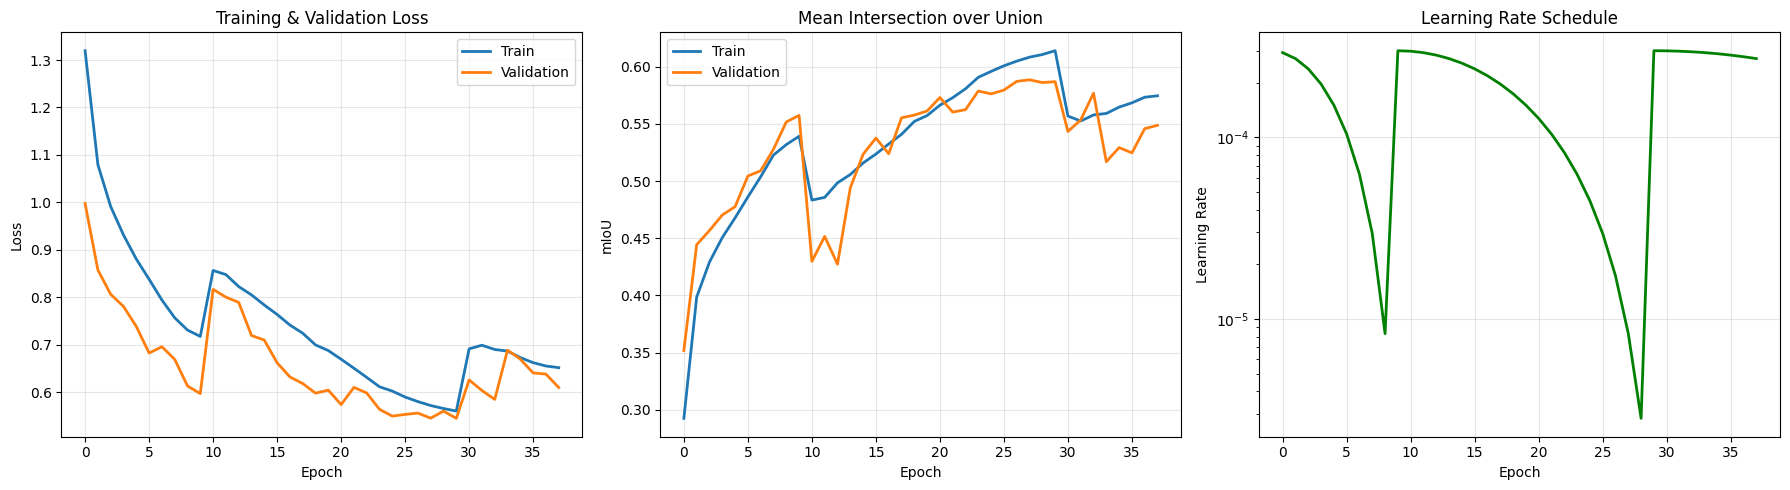

Creating class legend...


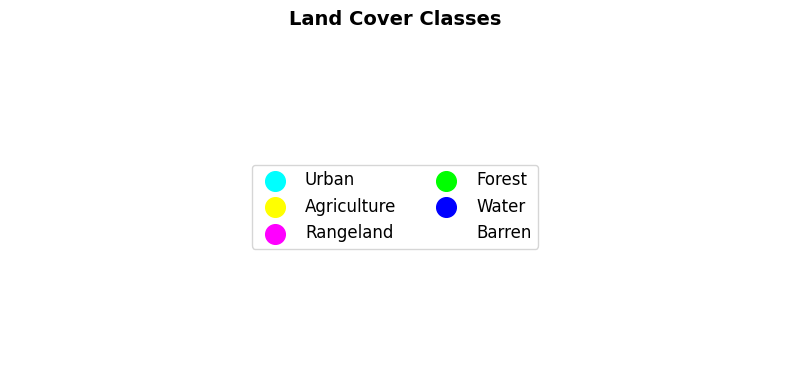


Evaluating on validation set...


/var/folders/zp/2k116x894351mf8z5t770n700000gn/T/ipykernel_58864/1218125435.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../outputs/checkpoi


FINAL VALIDATION METRICS
mIoU: 0.5884
Accuracy: 0.8635

Per-class IoU:
  urban       : 0.7609
  agriculture : 0.8673
  rangeland   : 0.3719
  forest      : 0.7723
  water       : 0.7072
  barren      : 0.6395

Visualizing sample predictions...


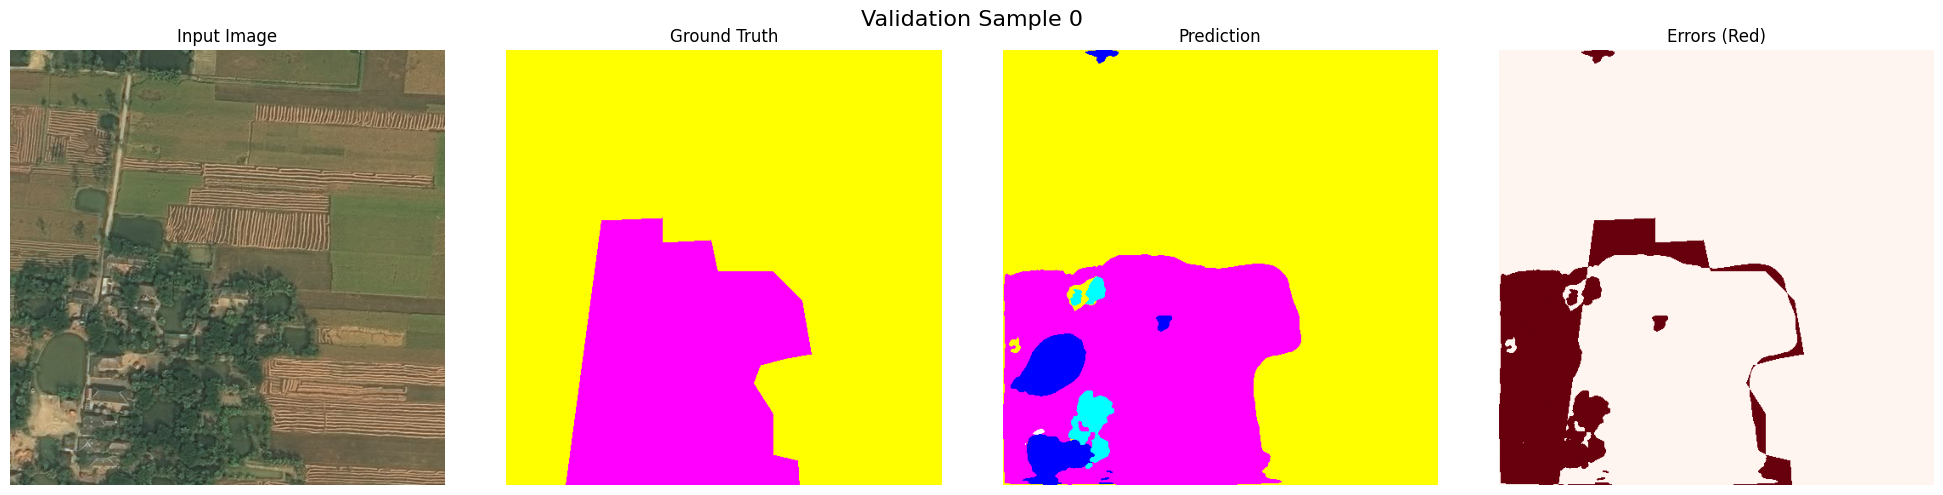

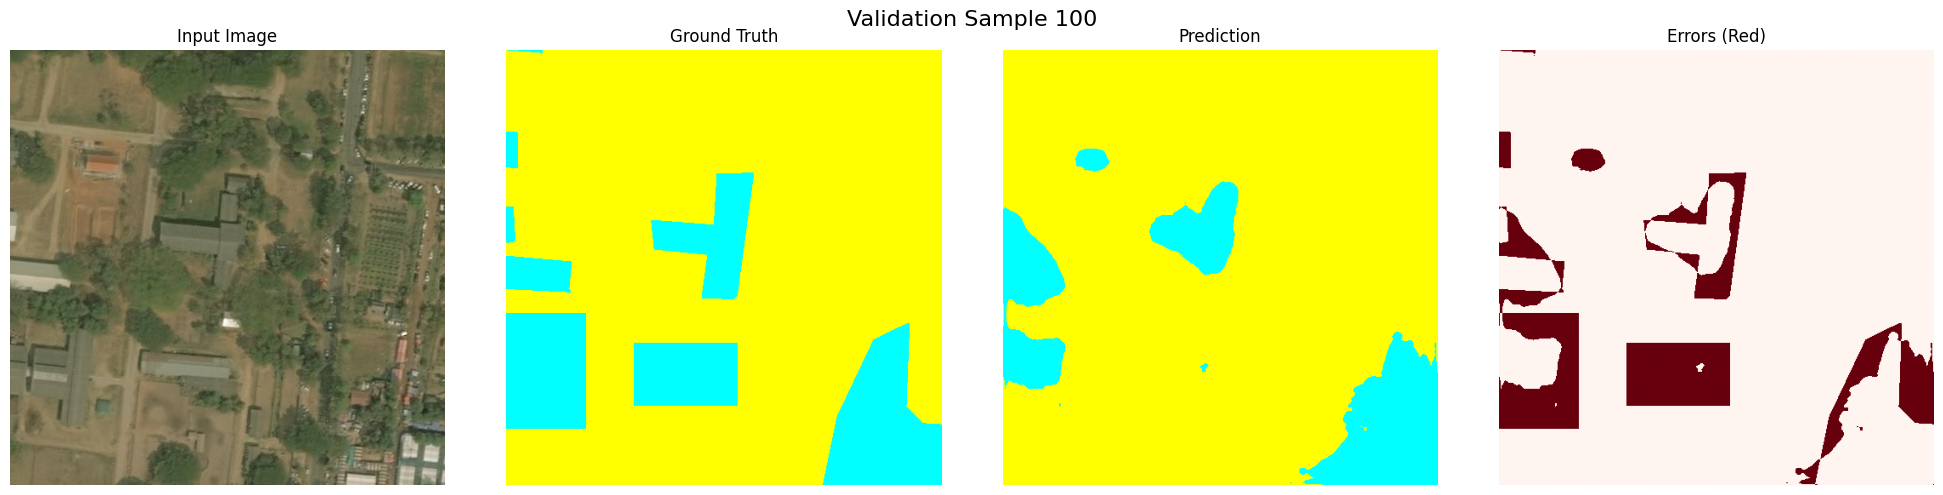

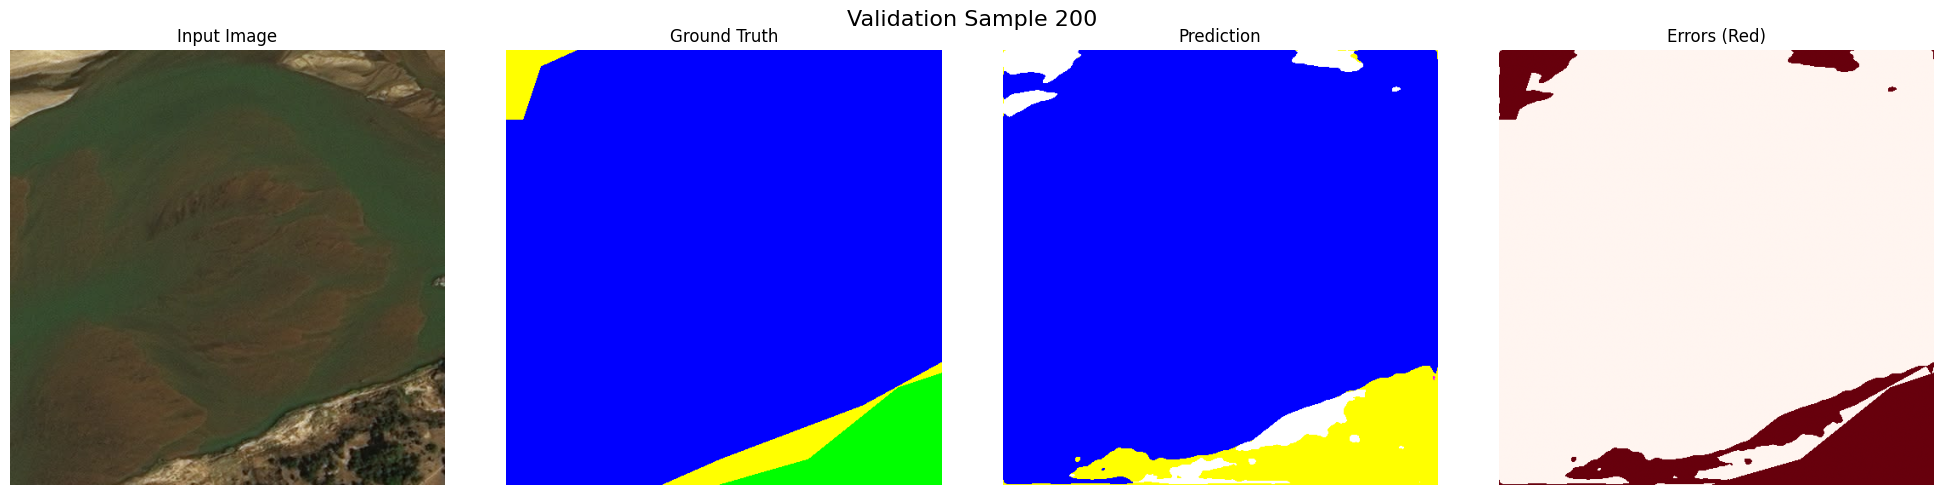

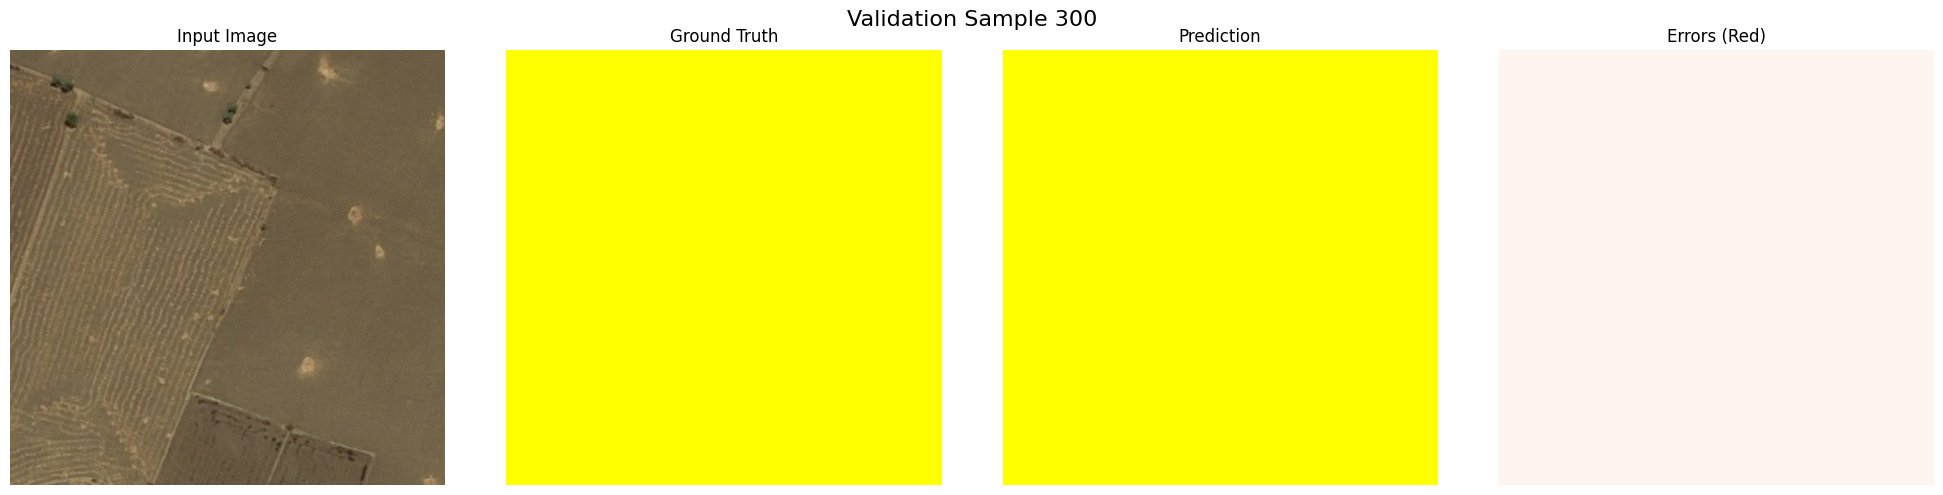

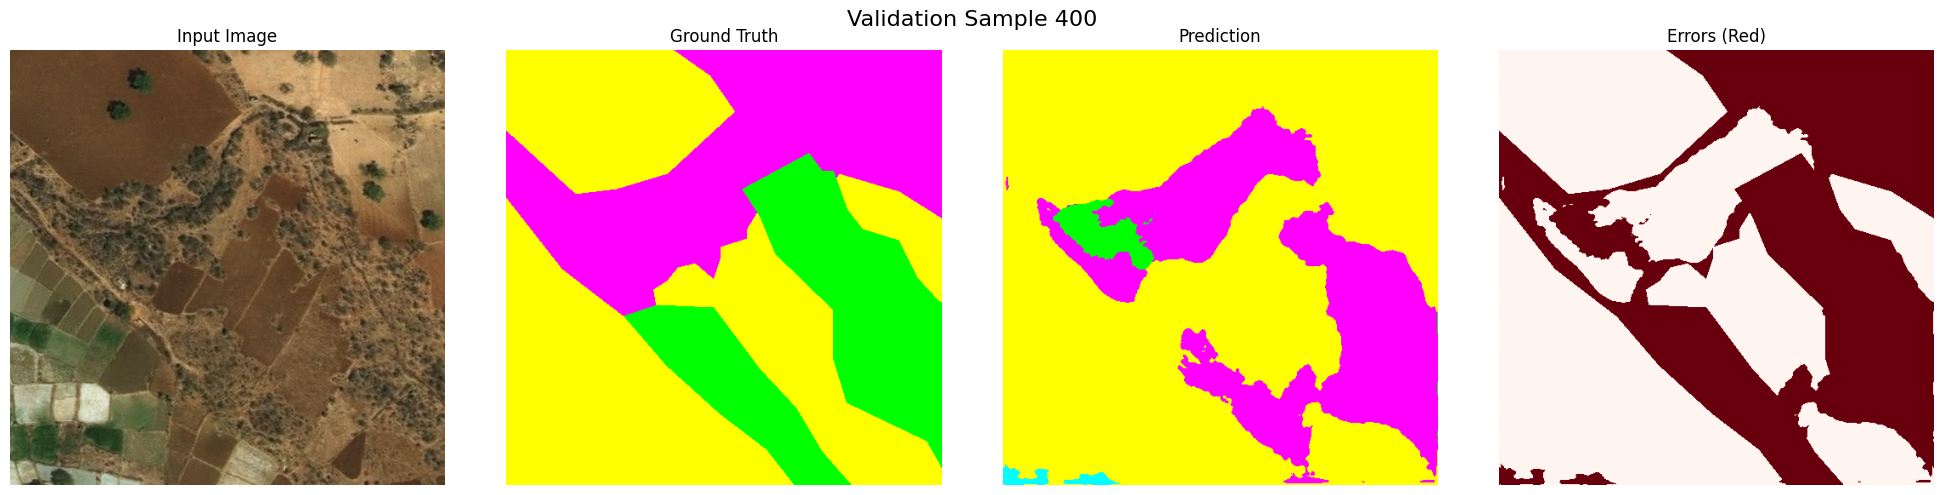


☑️ Evaluation completed!
Check outputs/figures/ for visualizations


In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from PIL import Image

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.visualization import (
    visualize_prediction, create_legend,
    plot_training_curves, create_error_atlas
)
from src.training.metrics import SegmentationMetrics

# ===== 1. Plot Training Curves =====
print("Plotting training curves...")
plot_training_curves(
    '../outputs/checkpoints/training_history.json',
    save_path='../outputs/figures/training_curves.png'
)

# ===== 2. Create Class Legend =====
print("Creating class legend...")
create_legend(save_path='../outputs/figures/class_legend.png')

# ===== 3. Evaluate on Validation Set =====
print("\nEvaluating on validation set...")

import torch
from torch.utils.data import DataLoader
from src.data.dataset import DeepGlobeDataset
from src.models.segmentation_model import create_model
from src.utils.torch_device import get_device

# Load model
device = get_device()
model = create_model(architecture='unet', encoder='resnet34', num_classes=7)
checkpoint = torch.load('../outputs/checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Load validation data
with open('../data/splits/val_files.json') as f:
    val_files = json.load(f)

val_dataset = DeepGlobeDataset(
    data_dir='../data/raw/train',
    file_list=val_files,
    transform=DeepGlobeDataset.get_val_transforms(),
    is_train=True
)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Compute metrics
metrics_tracker = SegmentationMetrics(num_classes=7, device=device)

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds_cpu = outputs.detach().to('cpu')
        masks_cpu = masks.to('cpu')
        metrics_tracker.update(preds_cpu, masks_cpu)
        # metrics_tracker.update(outputs, masks)

final_metrics = metrics_tracker.compute()

print("\n" + "=" * 60)
print("FINAL VALIDATION METRICS")
print("=" * 60)
print(f"mIoU: {final_metrics['mIoU']:.4f}")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print("\nPer-class IoU:")
for key, value in final_metrics.items():
    if key.startswith('IoU_'):
        class_name = key.replace('IoU_', '')
        print(f"  {class_name:12s}: {value:.4f}")
print("=" * 60)

# ===== 4. Visualize Sample Predictions =====
print("\nVisualizing sample predictions...")

# Get a few validation samples
sample_indices = [0, 100, 200, 300, 400]

for idx in sample_indices:
    image_tensor, mask = val_dataset[idx]

    # Denormalize image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = (image_tensor * std + mean).permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)

    # Predict
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Visualize
    visualize_prediction(
        image,
        mask.numpy(),
        pred,
        save_path=f'../outputs/figures/prediction_sample_{idx}.png',
        title=f'Validation Sample {idx}'
    )

print("\n☑️ Evaluation completed!")
print("Check outputs/figures/ for visualizations")